# PAI Scoring on radiographs

## Data
Radiographs are provided as 8 bit grayscale image clips 256x256 pixels centered on the apex. Each file has a label with the PAI scored by a human person. Later we will add on weigthtings for the humans compentence level because some scorings are done by undergraduate dentistry students.

## Todo
This version works on a limited set by one specialist candidate and overperforms. Have to change it to use the bigger database we have available with more thant 2 000 examples.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

import tensorflow as tf
import keras_tuner as kt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Do not show warnings
system = "jupyter"
data = "dag"
print("all loaded")

2023-07-04 10:55:52.558273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


all loaded


## Load and prepare data

In [2]:
# specify your directory and CSV file paths
if system == "linux":
    data_dir = "/fp/homes01/u01/ec-gerald/My Projects/ec192/data/endo-radiographs/clips"
elif system == "win":
    data_dir = r"\\aspasia.ad.fp.educloud.no\ec192\data\endo-radiographs\clips"
elif system == "jupyter":
    if data == "dag":
        data_dir = "/fp/projects01/ec192/data/endo-radiographs/dag/clips"
    elif data == "deniz":
        data_dir = "/fp/projects01/ec192/data/endo-radiographs/deniz/clips_balanced"
    
    
csv_file = os.path.join(data_dir, "codefile.csv")

image_size = 256

# load the CSV file using pandas
df = pd.read_csv(csv_file)
df.columns = ['filename', 'prediction']

# convert labels to str because ImageDataGenerator treats all inputs as strings
df['prediction'] = df['prediction'].astype(str)

# split the data into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# specify your target image size (this will be the input shape for your CNN)
target_size = (image_size, image_size)

# specify batch size
batch_size = 64  

# create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

Found 1849 validated image filenames belonging to 5 classes.
Found 463 validated image filenames belonging to 5 classes.


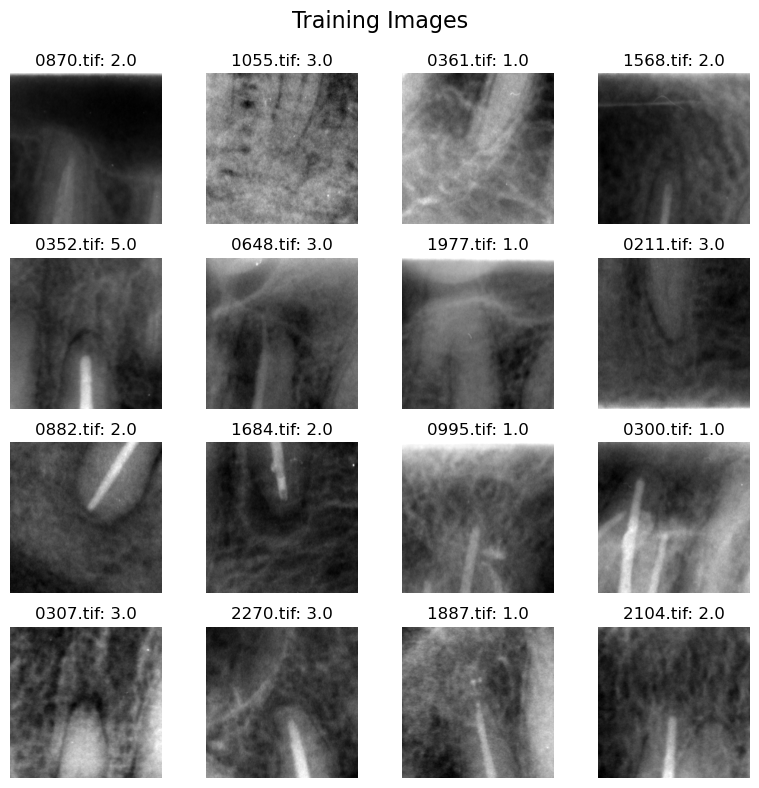

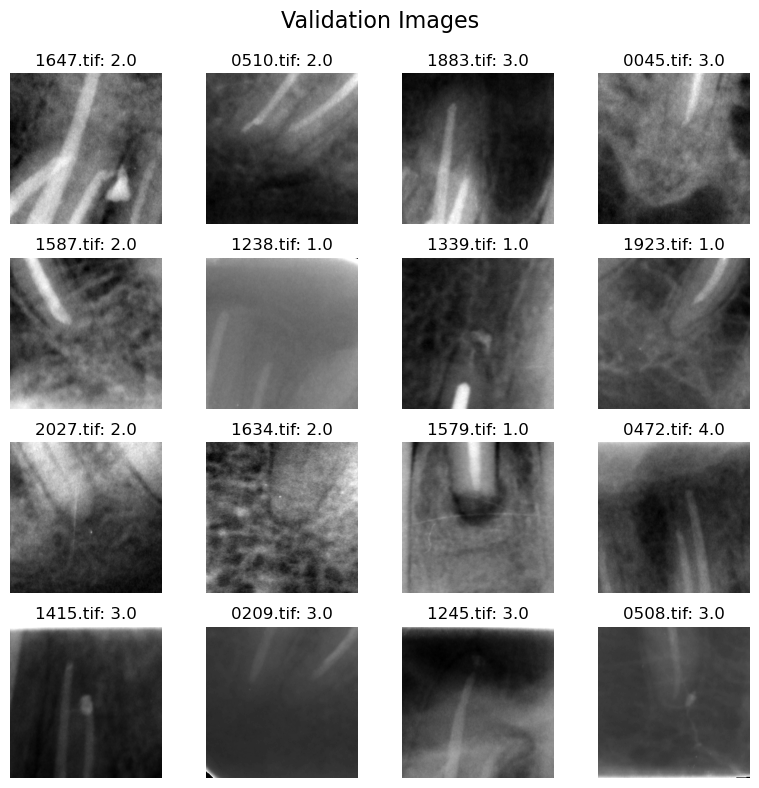

In [3]:
# Visualize data:
%matplotlib inline

# Function to get filenames from the generator
def get_filenames(generator):
    return generator.filenames

# Function to get class indices
def get_class_indices(generator):
    return generator.classes

# Fetch filenames and class indices for training and validation sets
train_filenames = get_filenames(train_generator)
train_class_indices = get_class_indices(train_generator)

valid_filenames = get_filenames(valid_generator)
valid_class_indices = get_class_indices(valid_generator)

# Get the class labels from class indices
label_map = (train_generator.class_indices)
inverse_label_map = {v: k for k, v in label_map.items()}

train_labels = [inverse_label_map[index] for index in train_class_indices]
valid_labels = [inverse_label_map[index] for index in valid_class_indices]

# Modified plot function to include file names and labels
def plot_images_with_labels(images, filenames, labels, title):
    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    axes = axes.ravel()

    for i in np.arange(0, 16):
        axes[i].imshow(images[i].reshape(target_size), cmap='gray')
        axes[i].set_title(f"{filenames[i]}: {labels[i]}")
        axes[i].axis('off')
        #print(filenames[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # adjust the top spacing
    plt.suptitle(title, fontsize=16)  # use suptitle for better positioning
    plt.show()

# Plot images with labels
train_images, _ = next(train_generator)  # Get a batch of images from the generator
valid_images, _ = next(valid_generator)

plot_images_with_labels(train_images, train_filenames, train_labels, 'Training Images')
print("\n\n")
plot_images_with_labels(valid_images, valid_filenames, valid_labels, 'Validation Images')

## Hyperparameter tuning
The following code is used to tune hyperparameters and find the most suitable model. Might need:
pip install -q -U keras-tuner

In [4]:
import tensorflow as tf
import keras_tuner as kt

# Defines the parameters to be tuned
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
  model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Define the number of steps per epoch
train_steps_per_epoch = len(train_df) // batch_size
valid_steps_per_epoch = len(valid_df) // batch_size

# Train the tuner
tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=50,
             steps_per_epoch=train_steps_per_epoch,
             validation_steps=valid_steps_per_epoch,
             callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_steps_per_epoch,
    callbacks=[early]
)

INFO:tensorflow:Reloading Tuner from dir/x/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
1                 |701               |layer_1
701               |1                 |layer_2
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



2023-07-04 10:56:38.688852: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/2


2023-07-04 10:56:39.025162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-04 10:56:40.866611: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [64,65536], In[1]: [784,1]
	 [[{{node sequential/dense/Relu}}]]
Traceback (most recent call last):
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/py

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 58, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/localscratch/254379/ipykernel_29243/574857890.py", line 39, in <module>
      tuner.search(train_generator,
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 230, in search
      self._try_run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
      self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
      results = self.run_trial(trial, *fit_args, **fit_kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
      return super().run_trial(trial, *fit_args, **fit_kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
      obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
      results = self.hypermodel.fit(hp, model, *args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
      return model.fit(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/fp/homes01/u01/ec-gerald/.conda/envs/MLEINVIRONMENT/lib/python3.11/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [64,65536], In[1]: [784,1]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_train_function_969]


In [ ]:
%matplotlib inline

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### Code from ChatGPT

Hyperparameters are the knobs that you tune to optimize your model performance. Some common hyperparameters in a Convolutional Neural Network (CNN) include:

    Number of layers
    Number of nodes (neurons) per layer
    Activation function
    Optimizer
    Learning rate
    Dropout rate
    Batch size
    Number of epochs

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    # Convolutional layers
    # The number of convolutional layers is a hyperparameter ranging from 2 to 5
    for i in range(hp.Int('conv_layers', 2, 5)):
        model.add(layers.Conv2D(hp.Int(f'conv_{i}_units',
                                       min_value=32,
                                       max_value=256,
                                       step=32), 
                                (3, 3), 
                                activation='relu'))
        # Following each Conv layer with a MaxPool layer
        model.add(layers.MaxPooling2D((2, 2)))

    # Flattening the output from the convolutional layers so it can be input to the dense layers
    model.add(layers.Flatten())

    # Dense layers
    # The number of dense layers is a hyperparameter ranging from 2 to 5
    for i in range(hp.Int('dense_layers', 2, 5)):
        model.add(layers.Dense(hp.Int(f'dense_{i}_units',
                                      min_value=32,
                                      max_value=256,
                                      step=32), 
                               activation=hp.Choice(f'dense_{i}_activation', 
                                                    values=['relu', 'tanh', 'sigmoid'])))
        # Optional: Adding a Dropout layer after each Dense layer for regularization
        if i < hp.Int('dense_layers', 2, 5) - 1:
            model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer with 5 units, one for each class
    model.add(layers.Dense(5, activation='softmax'))

    # Compiling the model
    # The learning rate is a hyperparameter, specified on a log scale
    model.compile(optimizer=keras.optimizers.Adam(
                      hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Defining the tuner
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,  # The number of different models to try
                     directory='my_dir',
                     project_name='hyperparam_tuning')

# Displaying a summary of the search space
tuner.search_space_summary()

# Performing the hyperparameter search
# Replace x, y, val_x, val_y with your actual data
tuner.search(x, y, epochs=10, validation_data=(val_x, val_y))

# Displaying a summary of the search results
tuner.results_summary()


# Models
Different models ar used:
- simple CNN model
- VGG16 based custom model for 8-bit greyscale images
- VGG19 pretrained model - transfer learning

In [ ]:
# VGG19 Transfer learning
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

pretrained = VGG19(include_top=False, input_shape=(224, 224, 3), 
                   weights='imagenet', pooling='max')
inputs = pretrained.input

for layer in pretrained.layers:
    layer.trainable = False
    
# Add fitting structure of dense layers:
hidden = Dense(128, activation='relu')(outputs)
dropout = Dropout(.3)(hidden)
hidden2 = Dense(128, activation='relu')(dropout)
dropout2 = Dropout(.3)(hidden2)
preds = Dense(5, activation='softmax')(dropout2)

model = Model(inputs, preds)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

model.summary()

# Run the model:
batch_size = 32
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
train_batches = train_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224), 
                                                    batch_size=batch_size)

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_batches = val_generator.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=batch_size)

model.fit(train_batches, 
          epochs=5, 
          validation_data=val_batches,
          steps_per_epoch=len(train_batches), 
          validation_steps=len(val_batches))

# Function to reverse preprocessing images for view:
def deprocess_vgg19(x):
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]  # Convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')  # Clip values to range [0, 255]
    return x

# Test the model:

n = 8
i = 1
for X, y in val_batches:
    preds = model.predict(X)
    preds = preds[1]
    true_label = labels[np.argmax(y)]
    label = labels[np.argmax(preds)]
    probability = preds[np.argmax(preds)]
    print(true_label + " Predicted: " + label + "; " + str(probability))
    # decoded_preds = decode_predictions(preds, top=1)
    fig = plt.figure()
    
    img = X[0].astype(np.uint8)
    img = deprocess_vgg19(X[0])
    # label = labels[np.argmax(y[0])]
    # predicted = decoded_preds[0]
    
    plt.imshow(img)
    # fig.suptitle('Truth: {}, Predicted: {}'.format(label, predicted))
    plt.show()
    print(i)
    if i > n: 
      break
    i += 1
